## Questions

1. How do we justify the ballistic approach?
2. How to correctly normalize the emitted flux?
3. Why $\Gamma_r$?
4. How did GRB affect the creation of life on earth

First we import necessary modules and define some physical constants:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
from dataclasses import dataclass

# SI units
SECOND = 1
YEAR = 365*24*3600 * SECOND
SPEED_OF_LIGHT = 299792458
MASS_PROTON = 1.673e-27
MASS_ELECTRON = 9.11e-31
MU_0 = 4 * np.pi * 1e-7
E_CHARGE = 1.602e-19
HBAR = 1.0546e-34
SIGMA_THOMSON = 6.652e-29
K1 = 4/3 * SIGMA_THOMSON * SPEED_OF_LIGHT * 1/(2*MU_0)
K2 = E_CHARGE / (2 * np.pi * MASS_ELECTRON)


## Step 1: dynamics

We employ ballistic dynamics in place of complicated relativistic fluid dynamics; we'll see later a posteriori that this is justified.

We consider that the source emits cold, spherical shells which expand with high speed, quantified by their Lorentz (gamma) factors. We suppose there is variability in the gamma factors so that collisions between the shells will develop, giving merged hot shells which immediately emit their internal energy in the form of synchrotron radiation, becoming cold again. The (relativistic) collision of two shells of gamma factors $\Gamma_1 > \Gamma_2$ gives a single shell of factor $\Gamma$ and internal energy $E_i$. They are related through the following equation:

$$
\begin{pmatrix}
m_1 \Gamma_1 \\
m_1 \Gamma_1 \beta_1
\end{pmatrix}
+
\begin{pmatrix}
m_2 \Gamma_2 \\
m_2 \Gamma_2 \beta_2
\end{pmatrix}
=
\begin{pmatrix}
\Gamma & \Gamma\beta \\
\Gamma\beta & \Gamma
\end{pmatrix}
\begin{pmatrix}
(m_1 + m_2)c^2 + E_i \\
0
\end{pmatrix}
$$

This has solution

$$
\beta = \frac{m_1 \beta_1 \Gamma_1 + m_2 \beta_2 \Gamma_2}{m_1 \Gamma_1 + m_2 \Gamma_2}
$$
$$
\Gamma = \frac{1}{\sqrt{1 - \beta^2}}
$$
$$
(m_1+m_2)c^2 + E_i = \frac{m_1 \Gamma_1 + m_2 \Gamma_2}{\Gamma}
$$

The injection of energy via emission of shells is supposed to occur such that the energy rate $\dot{E}$ is constant. We suppose that the injection phase lasts $\sim 5$ seconds and we vary the energy rate from $10^{41}$ to $10^{48}$ J/s to model different bursts.

The shells can be identified by their lagrangian coordinates $m$ equal to the total mass emitted up until that particular shell. To be more accurate, we associate to each injected shell an interval $[m, m+dm]$ where $dm$ is its mass. To a merged shell we'll associate the union of the intervals.

Variability in initial gamma factors is modeled by a "profile" function $\Gamma_{initial}(m/m_{tot})$ where $m_{tot}$ is the total emitted mass. In our code, this is either an arctangent (sigmoid) curve or a step function.

We have the implicit integral equation for $m_{tot}$:

$$
m_{tot} = \int dm = \int \frac{\dot{E} dt}{\Gamma_{initial}(m/m_{tot}) c^2}
$$

Our code solves this iteratively before giving the appropriate values of $\Gamma$ for the injected shells.

The end result of the dynamics is a single merged shell of mass $m_{tot}$. The dynamics code below computes the list of collisions, specified by time, location, mass and gamma factors of the initial two shells and of the merged shell thus formed.

The simulation is performed using a priority queue of events, which may be of "production" (creation of a shell) or of "collision" type. At the time of each production we predict the possible collisions with neighboring shells, and add them to the queue. At the time of each collision we deactivate two shells and produce a third one in their place, again predicting possible collisions with neighbors. If a collision event is treated that involves a deactivated shell, we skip it.

In [4]:

class Shell:
    def __init__(self, gamma, mass=1, initial_position=0, initial_time=0, lcoord=None):
        self.rapidity = np.arccosh(gamma)
        self.gamma = gamma
        self.betagamma = np.sinh(self.rapidity)
        self.speed = SPEED_OF_LIGHT * np.tanh(self.rapidity)
        self.mass = mass
        self.initial_position = initial_position
        self.initial_time = initial_time
        self.alive = True       # A shell object being alive means it's still active in the simulation
        self.lcoord = lcoord
    
    def position(self, time):
        return self.initial_position + self.speed * (time - self.initial_time)
        
    def kill(self):
        self.alive = False  # Shell objects are killed when they merge to form new shells

# Events will be put in a priority queue according to their time
# When treating an event, we call its process() method
class Event:
    def __init__(self, time, simulation):
        self.time = time
        self.simulation = simulation
    
    def process(self, verbose=True):
        pass

    def __lt__(self, other):
        return self.time < other.time

# Production of a shell, either at injection (r=0) or at merger
class ProductionEvent(Event):
    def __init__(self, time, simulation, gamma, mass=1, initial_position=0, lcoord=None):
        super().__init__(time, simulation)
        self.gamma = gamma
        self.mass = mass
        self.initial_position = initial_position
        self.lcoord = lcoord
    
    def process(self, verbose=True):
        shell = Shell(self.gamma, self.mass, self.initial_position, self.time, lcoord=self.lcoord)
        self.simulation.time = self.time

        # find where to put this shell in the shell list
        done = False
        index = -1
        for i, s in enumerate(self.simulation.shells):
            if s.position(self.time) >= self.initial_position:
                self.simulation.shells.insert(i, shell)
                index = i
                done = True
                break
        if not done:
            index = len(self.simulation.shells)
            self.simulation.shells.append(shell)

        # compute new possible collisions with adjacent shells
        if  0 <= index-1:
            anterior = self.simulation.shells[index-1]
            predict_collision(self.simulation, self.time, anterior, shell)
        if index+1 < len(self.simulation.shells):
            posterior = self.simulation.shells[index+1]
            predict_collision(self.simulation, self.time, shell, posterior)


# Collision of two shells. Processing this event puts a new ProductionEvent in the queue
# for the merged shell
class CollisionEvent(Event):
    def __init__(self, time, simulation, s1, s2):
        super().__init__(time, simulation)
        self.s1 = s1
        self.s2 = s2

    def process(self, verbose=True):
        self.simulation.time = self.time

        s1, s2 = self.s1, self.s2

        # check if shells are still alive
        if not s1.alive or not s2.alive:
            return

        # check that positions are indeed equal
        tol = 1e-5 * SPEED_OF_LIGHT
        assert abs(s1.position(self.time) - s2.position(self.time)) < tol, "Precision problems"
        
        # remove shells from list and kill them
        self.simulation.shells.remove(s1)
        self.simulation.shells.remove(s2)
        s1.kill()
        s2.kill()

        # compute parameters of merged shell
        mass, gamma, position, lcoord = compute_merged_shell(self.time, s1, s2)
        if verbose:
            print(f"mass={mass}, gamma={gamma}, position={position}")

        # produce merged shell
        e = ProductionEvent(self.time, self.simulation, gamma, mass, position, lcoord=lcoord)
        e.process(verbose=verbose)

        # register collision data
        collision = Collision(self.time, position, s1.mass, s2.mass, mass, s1.gamma, s2.gamma, gamma)
        self.simulation.collisions.append(collision)


@dataclass
class Collision:
    time: float
    position: float
    mass1: float
    mass2: float
    mass: float
    gamma1: float
    gamma2: float
    gamma: float

# collision of shell 1 and shell 2 gives shell with new parameters
def compute_merged_shell(now, s1: Shell, s2: Shell):
    mass = s1.mass + s2.mass
    beta = (s1.mass * s1.betagamma + s2.mass * s2.betagamma) / (s1.mass * s1.gamma + s2.mass * s2.gamma)
    rapidity = np.arctanh(beta)
    gamma = np.cosh(rapidity)

    # Approximate calculation
    # gamma = np.sqrt(s1.gamma * s2.gamma * (s1.mass * s1.gamma + s2.mass * s2.gamma)/(s2.mass * s1.gamma + s1.mass * s2.gamma))
    
    position = (s1.position(now) + s2.position(now)) / 2

    lcoord = [s2.lcoord[0], s1.lcoord[1]]

    return mass, gamma, position, lcoord

# this is pure kinematics in lab frame
def predict_collision(simulation, now, s1, s2):
    if s1.gamma > s2.gamma:
        deltax = s2.position(now) - s1.position(now)
        deltav = s1.speed - s2.speed
        collision_time = now + deltax / deltav

        simulation.queue.put(CollisionEvent(collision_time, simulation, s1, s2))

# Iterates implicit integral equation for the total injected mass
def estimate_injected_mass(energy_rate, injection_time, injection_interval,
                           injections, gamma_profile, gamma_args, mean_inverse_gamma, nb_iterations):
    injected_mass = 0
    injected_mass_estimate = energy_rate * injection_time / SPEED_OF_LIGHT**2 * mean_inverse_gamma

    for _ in range(nb_iterations):
        for time in injections:
            gamma = gamma_profile(injected_mass / injected_mass_estimate, **gamma_args)
            mass = energy_rate * injection_interval / gamma / SPEED_OF_LIGHT**2
            injected_mass += mass
        injected_mass_estimate = injected_mass
        injected_mass = 0
    
    return injected_mass_estimate



########## Initial gamma functions ###########
# nlcoord = normalized lagrangian coordinate
def gamma_profile_atan(nlcoord, gamma_min=100, gamma_max=400, compression=60):
    return (gamma_max-gamma_min) * (1 / np.pi * np.arctan(compression*(nlcoord-0.5))+0.5) + gamma_min

@np.vectorize
def gamma_profile_step(nlcoord, gamma_min=100, gamma_max=400):
    if nlcoord < 0.5: return gamma_min
    return gamma_max


class Simulation:
    def __init__(self, gamma_profile, energy_rate=1e45, injection_time=5, injection_interval=0.001,
                gamma_args={}):
        self.shells = []                # list of shells in spatial order (leftmost shell at index 0)
        self.queue = PriorityQueue()    # queue of events (productions and collisions)
        self.collisions = []            # list of collisions

        self.gamma_profile = gamma_profile
        self.energy_rate = energy_rate
        self.gamma_args = gamma_args

        self.injection_time = injection_time
        self.injection_interval = injection_interval
        self.injections = np.arange(0, injection_time, injection_interval)

        self.time = 0

        # compute mean gamma and mean inverse gamma
        nlcoord = np.linspace(0,1,1000)
        self.mean_gamma = gamma_profile(nlcoord).mean()
        self.mean_inverse_gamma = (gamma_profile(nlcoord)**-1.0).mean()

        # Iterate the implicit equation for total injected mass
        nb_iterations = 4
        self.injected_mass_estimate = estimate_injected_mass(energy_rate, injection_time, injection_interval,
                           self.injections, gamma_profile, gamma_args, self.mean_inverse_gamma, nb_iterations)
        
        # Put in place the injection events
        self.injected_mass = 0
        self.lcoords = []
        self.initial_gammas = []
        for time in self.injections:
            gamma = gamma_profile(self.injected_mass / self.injected_mass_estimate, **gamma_args)
            mass = energy_rate * injection_interval / gamma / SPEED_OF_LIGHT**2

            lcoord = [self.injected_mass]
            self.injected_mass += mass
            lcoord.append(self.injected_mass)

            e = ProductionEvent(time, self, gamma, mass, lcoord=lcoord)
            self.queue.put(e)

            self.lcoords.append(lcoord[0])
            self.initial_gammas.append(gamma)

    
    def run(self, amount=None, verbose=False):
        if amount is None:
            while not self.queue.empty():
                event = self.queue.get()
                event.process(verbose=verbose)
        
        else:
            for _ in range(amount):
                if self.queue.empty():
                    return
                event = self.queue.get()
                event.process(verbose=verbose)
    
    def generate_run(self, stop_every=100, verbose=False):
        while not self.queue.empty():
            self.run(amount=stop_every, verbose=verbose)
            yield self
        

In [5]:
simu = Simulation(gamma_profile_atan, energy_rate=1e45)
simu.run()

## Steps 2 and 3: shocked matter synchrotron emissions

- $\epsilon_*$ is the average energy dissipated per unit mass in the shock.
- $u_*$ is the....

The emssion process depends on the energy distribution of electrons, protons, and the magnetic field. We can calculate the magnetic field by using the following relation

$$ \epsilon_B u_* = \frac{B^2}{2 \mu_0} $$

i.e.

$$ B = \sqrt{2 \mu_0 \epsilon_B u_*} $$

where $u_* = \rho_* \epsilon_*$. Asumming the equipartition beetween protons, electrons, and the magnetic field, $\epsilon_B$ can be considered to be 1/3. $\rho_*$ can be estimated as follows

$$ \rho_* = \frac{M_*}{\Gamma_* 4\pi R^2 \Delta_*} \approx \frac{\dot{M}_*}{\Gamma_* 4\pi R^2 c} $$

$$\approx \frac{\dot{M}_{shock}}{4\pi R^2 c} \approx \frac{\dot{E}}{\bar{\Gamma}4\pi R^2 c^3} $$

where $\bar{\Gamma}$ denotes the average of $\Gamma$. We are left with calculating $\epsilon_*$. For this, we can apply the formula

$$ \frac{\epsilon_*}{c^2} = \frac{1}{2} \left[ \sqrt{\frac{\Gamma_1}{\Gamma_2}} + \sqrt{\frac{\Gamma_2}{\Gamma_1}} \right] - 1 $$


### Distribution of accelerated electrons
We assume that a fraction $\zeta$ of electrons are accelerated by a fraction $\epsilon_e = 1/3$ of the energy and acquire a power law distribution of gamma factors of power $-p$. Thus
$$ n_e^{acc} = \int_{\gamma_m}^{\gamma_M} n(\gamma) \, d\gamma = \zeta \frac{\rho_*}{m_p} $$
$$ u_e^{acc} = \int_{\gamma_m}^{\gamma_M} n(\gamma) \gamma m_e c^2 \, d\gamma = \epsilon_e u_* $$

and
$$ n(\gamma) = A\gamma^{-p} $$
for $\gamma_m \leq \gamma \leq \gamma_M$, $n(\gamma)=0$ elsewhere.

This gives, in the limit $\gamma_M \to \infty$,
$$ \gamma_m = \left(\frac{p-2}{p-1}\right) \frac{m_p}{m_e} \frac{\epsilon_e \epsilon_*}{\zeta} $$
$$ A = (p-1) \zeta \frac{\rho_*}{m_p} \gamma_m^{p-1} $$

In SI units:

$$P_{syn}(\gamma) = K_1 B^2 \gamma^2 = \frac{4}{3} \sigma_T c \frac{B^2}{2\mu_0} \gamma^2$$

$$\nu_{syn}(\gamma) = K_2 B \gamma^2 = \frac{e}{2\pi m_e}B \gamma^2 $$

$$\sigma_T = 6.652 \times 10^{-29} \text{ m}^2$$

(Develop more what this means here.)

We want to determine the Lorentz factor of the accelerated electrons.

To do so, we compute the loss of energy with the formula:

$$
    \frac{d (\gamma m_e c^2)}{dt} = -\underbrace{P(\gamma)}_{=K_1 B^2 \gamma^2} - \underbrace{\frac{\gamma m_e c^2}{t_{dyn}'}}_{\text{expansion loss}}
$$

In the right-hand side, the first term expresses the loss via synchroton radiation and the second term expresses the loss of energy via expansion.

We define the cooling Lorentz factor as
$$
\gamma_c \equiv \frac{m_e c^2}{t'_{dyn} K_1 B^2}
$$
so that the loss of energy becomes:
$$
\frac{d\gamma}{dt} = -\frac{1}{t'_{dyn}}\left( \frac{\gamma^2}{\gamma_c} + \gamma \right)
$$
or equivalently:
$$
\frac{d\gamma}{\gamma} - \frac{d\gamma}{\gamma+\gamma_c} = - \frac{dt}{t'_{dyn}}
$$

Now by integrating between initial time and time $t$ we get an analytical solution:
$$
\gamma(t, \gamma_0) = \dfrac{\gamma_c}{\left( 1 + \frac{\gamma_c}{\gamma_0} \right) e^{t / t'_{dyn}} - 1}
$$

We see that $\gamma_c$ is the characteristic saturation scale of Lorentz factors at which the cooling becomes fast, i.e. for $\gamma_0 \ll \gamma_c$ we have $\gamma \sim \gamma_0 e^{-t/t'_{dyn}}$ and for $\gamma_0 \gg \gamma_c$ we have $\gamma \sim \gamma_c e^{-t/t'_{dyn}}$, so that a sharp decrease from $\gamma_0$ to $\gamma_c$ is expected near $t=0$ in the latter case.

We also have the inverse relation:
$$
\gamma_0(t, \gamma) = \dfrac{\gamma_c}{\left( 1 + \frac{\gamma_c}{\gamma} \right) e^{-t / t'_{dyn}} - 1}
$$

Finally, we can compute the time at which the accelerated electron has Lorentz Factor $\gamma_e$ assuming it has initially Lorentz Factor $\gamma_0$:
$$
t = t'_{dyn} \left[ \ln\left(1 + \frac{\gamma_c}{\gamma_e}\right) - \ln\left(1 + \frac{\gamma_c}{\gamma_0}\right) \right]
$$

The equation for conservation of number of particles reads
$$
n(\gamma, t) d\gamma = n_0 (\gamma_0(\gamma, t)) d\gamma_0
$$

The first derivative of initial Lorentz factor $\gamma_0$ with respect to the factor $\gamma$ at time $t$ reads:
$$
\frac{d\gamma_0}{d\gamma} = \left(\frac{\gamma_0}{\gamma}\right)^2 e^{-t / t'_{dyn}}
$$

Therefore, the mean density of electrons accelerated at Lorentz factor $\gamma_e$ reads:
$$
\overline{n(\gamma_e)} = \int_0^{t'_{dyn}} n(\gamma_e, t) dt = \int_0^{t'_{dyn}} n_0(\gamma_0(\gamma_e, t)) \left(\frac{\gamma_0}{\gamma}\right)^2 e^{-t / t'_{dyn}} \, dt
$$

We define $t_m = t_m(\gamma_e)$ as the time in which electrons initially at $\gamma_m$ cool down to $\gamma_e$. Similarly, electrons initially with $\gamma_0 \to \infty$ cool down to $\gamma_e$ in a finite time $t_\infty = t_\infty(\gamma_e)$. 

We'll discuss different limits of $\overline{n(\gamma_e)}$ following the relative sizes of $\gamma_c$, $\gamma_e$ and $\gamma_m$, the minimum Lorentz Factor in the Fermi acceleration model.

Firstly, all our discussion pertains to the case of _fast cooling_, i.e. $\gamma_m > \gamma_c$, all the involved (initial) Lorentz factors are greater than the characteristic saturation scale at which the cooling becomes faster than exponential.

We have then two possible situations:
- $\gamma_m > \gamma_e$, in which case the integral must be performed between $t_m$ and $t_\infty$;
- $\gamma_m < \gamma_e$, in which case the integral must be performed between $0$ and $t_\infty$.

We'll evaluate the integral by using the substitution
$$
u = \left( 1 + \frac{\gamma_c}{\gamma_e} \right) e^{- t / t'_{dyn}} - 1
$$
In the case $\gamma_e < \gamma_m$, we get:
$$
\overline{n(\gamma_e)} = \dfrac{ \gamma_c^{-p+2} }{\left(\gamma_e + \gamma_c\right)^2} \int_{u_\infty}^{u_m} u^{p-2}(u+1) du
$$
Plugging in $u_m = \gamma_c / \gamma_m$ and $u_\infty = 0$ yields  
$$
\overline{n(\gamma_e)} \propto \dfrac{1}{(\gamma_e + \gamma_c)^2}
$$

We still have not compared $\gamma_e$ to $\gamma_c$. If $\gamma_e \ll \gamma_c$, we get
$$
\overline{n(\gamma_e)} \propto \text{const.}
$$
while for $\gamma_c \ll \gamma_e < \gamma_m$ we have
$$
\overline{n(\gamma_e)} \propto \gamma_e^{-2}
$$

Now let's see the case $\gamma_e > \gamma_m$:
$$
\overline{n(\gamma_e)} = \dfrac{ \gamma_c^{-p+2} }{\left(\gamma_e + \gamma_c\right)^2} \int_{u_\infty}^{u_e} u^{p-2}(u+1) du
$$
Here $u_e = \gamma_c / \gamma_e$, so that we get
$$
\overline{n(\gamma_e)} \propto \dfrac{1}{\left(\gamma_e + \gamma_c\right)^2} \left[ \frac{\left(\frac{\gamma_c}{\gamma_e}\right)^p}{p} + \frac{\left(\frac{\gamma_c}{\gamma_e}\right)^{p-1}}{p-1} \right] 
$$
The dominant term since $\gamma_e > \gamma_m > \gamma_c$ is thus
$$
\overline{n(\gamma_e)} \propto \gamma_e^{-2} \gamma_e^{-p+1} = \gamma_e^{-(p+1)}
$$


In [42]:
@dataclass
class Emission:
    time: float
    t_obs: float
    position: float
    gamma_r: float
    energy: float
    e_star: float
    rho_star: float
    gamma_m: float
    b_field: float
    tp_dyn: float
    gamma_c: float
    nu_m: float
    nu_c: float

    def u_nu(self, freq):
        p = 2.2
        nu_c, nu_m = self.nu_c, self.nu_m
        fast_cooling = nu_c < nu_m

        # Convert frequency to comoving frame
        doppler_factor = np.exp(np.arccosh(self.gamma_r))
        freq /= doppler_factor

        if fast_cooling:
            if freq < nu_c:
                return freq**(1/3)
            elif freq < nu_m:
                normB = nu_c**(5/6)
                return normB*freq**(-1/2)
            else:
                normC = nu_c**(5/6) * nu_m**((p-1)/2)
                return normC * freq**(-p/2)
        else:
            if freq < nu_m:
                return freq**(1/3)
            elif freq < nu_c:
                normB = nu_m**(p/2 - 1/6)
                return normB * freq**(-(p-1)/2)
            else:
                normC = nu_m**(p/2 - 1/6) * nu_c**0.5
                return normC * freq**(-p/2)

    # Number density of photons at a given frequency IN OBSERVER FRAME
    # This N(freq) = const. u_freq / h freq
    def spectrum(self, freq):
        p = 2.2
        nu_c, nu_m = self.nu_c, self.nu_m
        fast_cooling = nu_c < nu_m

        # Convert frequency to comoving frame
        doppler_factor = np.exp(np.arccosh(self.gamma_r))
        freq /= doppler_factor

        # Spectrum is u_nu / h nu
        if fast_cooling:
            if freq < nu_c:
                return freq**(-2/3)
            elif freq < nu_m:
                normB = nu_c**(5/6)
                return normB*freq**(-3/2)
            else:
                normC = nu_c**(5/6) * nu_m**((p-1)/2)
                return normC * freq**(-p/2 - 1)
        else:
            if freq < nu_m:
                return freq**(-2/3)
            elif freq < nu_c:
                normB = nu_m**(p/2 - 1/6)
                return normB * freq**(-(p+1)/2)
            else:
                normC = nu_m**(p/2 - 1/6) * nu_c**0.5
                return normC * freq**(-p/2 - 1)

    # Normalized integral of N(freq)
    def flux_frac(self, lowerlim, upperlim):
        p = 2.2
        nu_c, nu_m = self.nu_c, self.nu_m
        fast_cooling = nu_c < nu_m

        # Convert frequencies to comoving frame
        doppler_factor = np.exp(np.arccosh(self.gamma_r))
        lowerlim /= doppler_factor
        upperlim /= doppler_factor
        
        # Normalization constants in regions B and C
        normB = nu_c**(5/6)
        normBslow = nu_m**(p/2 - 1/6)
        normC = normB * nu_m**((p-1)/2)
        normCslow = normBslow*nu_c**0.5

        def aa(lo, up):
            return 3*(up**(1/3) - lo**(1/3))
        
        def bb(lo, up):
            if fast_cooling:
                return -2*normB*(up**(-0.5) - lo**(-0.5))
            else:
                return -2*normBslow/(p-1) * (up**(-(p-1)/2) - lo**(-(p-1)/2))
        
        def cc(lo, up):
            if fast_cooling:
                return -2*normC/p * (up**(-p/2) - lo**(-p/2))
            else:
                return -2*normCslow/p * (up**(-p/2) - lo**(-p/2))
        
        def ab(lo, up): 
            if nu_c < nu_m:
                return aa(lo, nu_c) + bb(nu_c, up)
            else:
                return aa(lo, nu_m) + bb(nu_m, up)
        
        def ac(lo, up):
            if nu_c < nu_m:
                return aa(lo, nu_c) + bb(nu_c, nu_m) + cc(nu_m, up)
            else:
                return aa(lo, nu_m) + bb(nu_m, nu_c) + cc(nu_c, up)
        
        def bc(lo, up):
            if nu_c < nu_m:
                return bb(lo, nu_m) + cc(nu_m, up)
            else:
                return bb(lo, nu_c) + cc(nu_c, up)
            
        nu_1, nu_2 = nu_c, nu_m
        if not fast_cooling:
            nu_1, nu_2 = nu_2, nu_1

        if lowerlim < nu_1:
            if upperlim < nu_1:
                f = aa
            elif upperlim < nu_2:
                f = ab
            else:
                f = ac
        elif lowerlim < nu_2:
            if upperlim < nu_2:
                f = bb
            else:
                f = bc
        else:
            f = cc

        norm = ac(0, np.inf)
        
        return f(lowerlim,upperlim)/norm
    
    # Integral of N(E) between two frequencies in observer frame
    def flux_between(self, lowerlim, upperlim):
        return self.energy * self.flux_frac(lowerlim, upperlim)


    # Fraction of energy between two frequencies IN OBSERVER FRAME
    def energy_frac(self, lowerlim, upperlim):
        p = 2.2
        nu_c, nu_m = self.nu_c, self.nu_m

        # Convert frequencies to comoving frame
        doppler_factor = np.exp(np.arccosh(self.gamma_r))
        lowerlim /= doppler_factor
        upperlim /= doppler_factor
        
        # Normalization constants in regions B and C
        normB = nu_c**(5/6)
        normBslow = nu_m**(p/2 - 1/6)
        normC = normB * nu_m**((p-1)/2)
        normCslow = normBslow*nu_c**0.5

        # Domain is divided in regions A, B, C
        # There are six possibilities
        def aa(lowerlim, upperlim):
            return 3/4 * (upperlim**(4/3) - lowerlim**(4/3))
        
        def bb(lowerlim, upperlim):
            if nu_c < nu_m: # fast cooling
                return 2*normB * (upperlim**(1/2) - lowerlim**(1/2))
            else:           # slow cooling
                return 2*normBslow/(3-p) * (upperlim**((3-p)/2) - lowerlim**((3-p)/2))
        
        def cc(lowerlim, upperlim):
            if nu_c < nu_m:
                return 2*normC/(2-p) * (upperlim**(1-p/2) - lowerlim**(1-p/2))
            else:
                return 2*normCslow/(p-2) * (lowerlim**(-p/2+1) - upperlim**(-p/2+1))
        
        def ab(lowerlim, upperlim):
            if nu_c < nu_m:
                return aa(lowerlim, nu_c) + bb(nu_c, upperlim)
            else:
                return aa(lowerlim, nu_m) + bb(nu_m, upperlim)
        
        def ac(lowerlim, upperlim):
            if nu_c < nu_m:
                return aa(lowerlim, nu_c) + bb(nu_c, nu_m) + cc(nu_m, upperlim)
            else:
                return aa(lowerlim, nu_m) + bb(nu_m, nu_c) + cc(nu_c, upperlim)
        
        def bc(lowerlim, upperlim):
            if nu_c < nu_m:
                return bb(lowerlim, nu_m) + cc(nu_m, upperlim)
            else:
                return bb(lowerlim, nu_c) + cc(nu_c, upperlim)
        
        if nu_c < nu_m:
            if lowerlim < nu_c:
                if upperlim < nu_c:
                    f = aa
                elif upperlim < nu_m:
                    f = ab
                else:
                    f = ac
            elif lowerlim < nu_m:
                if upperlim < nu_m:
                    f = bb
                else:
                    f = bc
            else:
                f = cc
        else:
            if lowerlim < nu_m:
                if upperlim < nu_m:
                    f = aa
                elif upperlim < nu_c:
                    f = ab
                else:
                    f = ac
            elif lowerlim < nu_c:
                if upperlim < nu_c:
                    f = bb
                else:
                    f = bc
            else:
                f = cc

        return f(lowerlim, upperlim) / ac(0, np.infty)

    
    def energy_between(self, lowerlim, upperlim):
        return self.energy * self.energy_frac(lowerlim, upperlim)


def emission_from_collision(col: Collision, simu: Simulation):
    t_obs = col.time - col.position / SPEED_OF_LIGHT
    gamma_r = np.sqrt(col.gamma1 * col.gamma2)
    min_mass = min(col.mass1, col.mass2)
    energy = min_mass * SPEED_OF_LIGHT**2 * (col.gamma1 + col.gamma2 - 2*gamma_r)
    e_star = ((np.sqrt(col.gamma1/col.gamma2)+np.sqrt(col.gamma2/col.gamma1))/2 - 1)*SPEED_OF_LIGHT**2
    rho_star = simu.energy_rate / (4*np.pi*col.position**2 * simu.mean_gamma**2 * SPEED_OF_LIGHT**3)

    p = 2.2
    gamma_m = (p-2)/(p-1) * MASS_PROTON/MASS_ELECTRON * e_star / (3 * 0.5 * SPEED_OF_LIGHT**2)
    #gamma_m = max(1, gamma_m)
    b_field = np.sqrt(MU_0 * rho_star * e_star * 2/3)

    tp_dyn = col.position/(gamma_r * SPEED_OF_LIGHT)
    gamma_c = MASS_ELECTRON * SPEED_OF_LIGHT**2 / (tp_dyn * K1 * b_field**2)
    #gamma_c = max(1, gamma_c)

    nu_m = K2 * b_field * gamma_m**2
    nu_c = K2 * b_field * gamma_c**2

    return Emission(col.time, t_obs, col.position, gamma_r, energy,
                    e_star, rho_star, gamma_m, b_field, tp_dyn,
                    gamma_c, nu_m, nu_c)


def emission_list_from_simulation(simu: Simulation):
    return [emission_from_collision(col, simu) for col in simu.collisions]

In [43]:
emissions = emission_list_from_simulation(simu)

## Step 4: plots

In [44]:
######## Emission profiles for bolometric plots ########
#@np.vectorize
def emission_profile_box(t, boxsize=0.03):       # ad-hoc box profile
    # if 0 <= t and t < boxsize:
    #     return 1/boxsize
    # return 0
    return (0<=t).astype(int) * (t<boxsize).astype(int) * (1/boxsize)

#@np.vectorize
def emission_profile_triangle(t, boxsize=0.03):  # ad-hoc triangle profile
    # if 0 <= t and t < boxsize:
    #     return 2/boxsize * (1 - t/boxsize)
    # return 0
    return (0<=t).astype(int)*(t<boxsize).astype(int)*(2/boxsize)*(1 - t/boxsize)

        
def plot_initial_gamma(simu, ax=None):

    if ax is not None:
        plt.sca(ax)

    plt.plot(np.asarray(simu.lcoords)/simu.injected_mass, simu.initial_gammas)
    plt.title("Initial gamma profile")
    plt.xlabel("Normalized lagrangian coordinate $m/m_{tot}$")
    plt.ylabel("Shell Lorentz factor")
    plt.grid()

    if ax is None:
        plt.show()


def plot_emissions(emissions, axes=None):
    t_init = emissions[0].t_obs

    emission_time = [e.time for e in emissions]
    arrival_time = [e.t_obs-t_init for e in emissions]
    emission_position = [e.position for e in emissions]
    emission_gamma_r = [e.gamma_r for e in emissions]
    emission_deltat = np.asarray(emission_position) / (2 * np.asarray(emission_gamma_r)**2 * SPEED_OF_LIGHT)
    emission_energy = [e.energy for e in emissions]


    if axes is not None:
        ax1, ax3 = axes
    else:
        fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(4,8))
    plt.tight_layout()
    ax2 = ax1.twinx()
    ax4 = ax3.twinx()

    ax1.scatter(arrival_time, emission_time, marker='.', s=0.5)
    ax1.set_ylabel("$t_e$ (s)")
    ax2.scatter(arrival_time, emission_deltat, marker='.', s=0.5, color='k')
    ax2.set_ylabel("$\\Delta t$ (s)")

    ax3.scatter(arrival_time, emission_energy, marker='.', s=0.5)
    ax3.set_ylabel("$e$")
    ax4.scatter(arrival_time, emission_gamma_r, marker='.', s=0.5, color='k')
    ax4.set_ylabel("$\\Gamma_r$")

    if axes is None:
        plt.show()


def plot_collisions(collisions, ax=None):
    time = [col.time for col in collisions]
    position = [col.position for col in collisions]

    if ax is not None:
        plt.sca(ax)
    plt.scatter(time, position, marker='.')
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.title("Locus of collisions")
    plt.yscale("log")
    plt.xscale("log")
    if ax is None:
        plt.show()

def lcoord2plottable(lcoords, quantities):
    res = []
    for lcoord, qtty in zip(lcoords, quantities):
        res.append((lcoord[1], qtty))
        res.append((lcoord[0], qtty))
    return np.asarray(res).T

def plot_gamma(simu, ax=None):
    lcoords = [shell.lcoord for shell in simu.shells]
    gammas = [shell.gamma for shell in simu.shells]
    x, y = lcoord2plottable(lcoords, gammas)

    if ax is not None:
        plt.sca(ax)
    plt.plot(x, y)
    plt.xlabel("Lagrangian coordinate")
    plt.ylabel("Gamma factor")
    plt.title(f"Gamma factor distribution, t={simu.time}")
    if ax is None:
        plt.show()

def plot_burst_profile(emissions, lowerlim=0, upperlim=np.infty, emission_profile=emission_profile_triangle,
                       maxtime=None, npoints=501, emission_args={}, ax=None, label=None):
    t_init = emissions[0].t_obs
    if maxtime:
        t_end = t_init + maxtime
    else:
        t_end = emissions[-1].t_obs+1

    t = np.linspace(t_init, t_end, npoints)

    burst = 0 * t
    for e in emissions:
        flux = e.flux_between(lowerlim, upperlim)
        dt_obs = e.position / (2 * e.gamma_r**2 * SPEED_OF_LIGHT)
        burst += flux * emission_profile(t - e.t_obs, boxsize=dt_obs, **emission_args)

    # Normalize flux
    #burst = burst / max(burst) # TODO: appropriately model experimental normalization

    if ax is not None:
        plt.sca(ax)

    plt.plot(t-t_init, burst, label=label)
    plt.title("Synthetic lightcurve")
    plt.xlabel("Arrival time $t_{obs} (s)$")
    plt.ylabel("Emitted flux (number of photons)")
    
    if ax is None:
        plt.show()


def plot_multiple_burst_profiles(emissions, lims=[(0, np.infty)], labels=[None], emission_profile=emission_profile_triangle,
                                 maxtime=None, npoints=501, emission_args={}, ax=None):    
    if ax is not None:
        plt.sca(ax)
    
    for (lowerlim, upperlim), label in zip(lims, labels):
        plot_burst_profile(emissions, lowerlim, upperlim, emission_profile, maxtime, npoints, emission_args, plt.gca(), label)

    plt.legend(loc='upper right')
    if ax is None:
        plt.show()

def standard_bolometric_plot(emissions, emission_profile=emission_profile_triangle, maxtime=None, npoints=501, only_first=6, ax=None):
    const = E_CHARGE / (2 * np.pi * HBAR)
    nu_25keV = const * 25e3
    nu_50keV = const * 50e3
    nu_100keV = const * 100e3
    nu_300keV = const * 300e3
    nu_1MeV = const * 1e6
    nu_1GeV = const * 1e9

    lims = [(nu_25keV, nu_50keV), (nu_50keV, nu_100keV), (nu_100keV, nu_300keV), (nu_300keV, nu_1MeV),
            (nu_1MeV, nu_1GeV), (nu_1GeV, np.infty)]
    labels = ['25 keV - 50 keV', '50 keV - 100 keV', '100 keV - 300 keV', '300 keV - 1 MeV',
              '1 MeV - 1 GeV', '> 1 GeV']

    plot_multiple_burst_profiles(emissions, lims[:only_first], labels[:only_first], emission_profile, maxtime, npoints, ax=ax)


def compute_spectrum(emissions):
    nb_points = 501
    energies = np.logspace(-9, 9, nb_points) # in eV
    frequencies = energies * E_CHARGE/(2*np.pi*HBAR)
    
    spec = frequencies*0
    for e in emissions:
        for n,freq in enumerate(frequencies):
            spec[n] += e.energy * e.spectrum(freq)

    return energies, spec

def plot_spectrum(emissions, ax=None):
    if ax is not None:
        plt.sca(ax)
    
    energies, spec = compute_spectrum(emissions)
    
    plt.loglog(energies/1e6, spec)
    plt.xlabel("Photon energy (MeV)")
    plt.ylabel("Flux (arbitrary units)")
    plt.title("Synthetic spectrum")

    if ax is None:
        plt.show()

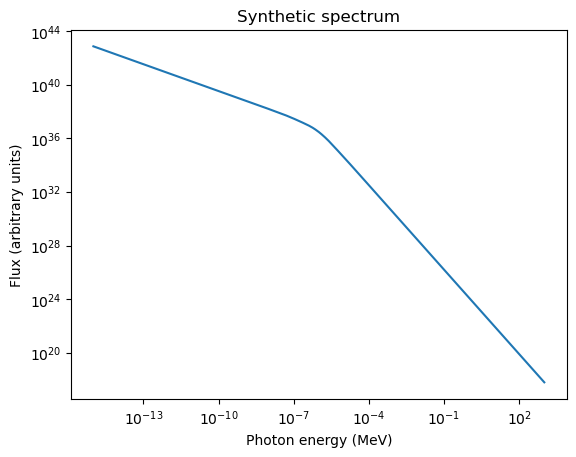

In [45]:
plot_spectrum(emissions)

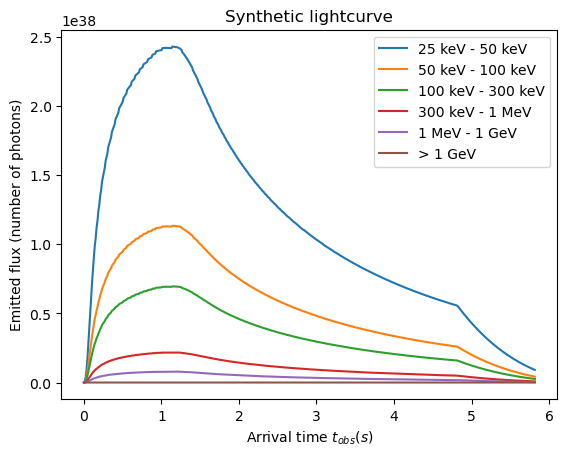

In [46]:
standard_bolometric_plot(emissions)

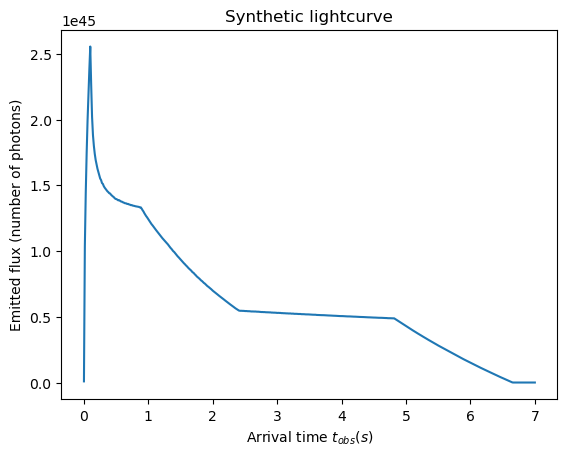

In [11]:
plot_burst_profile(emissions, 0, np.infty, emission_profile=emission_profile_box, maxtime=7)

In [12]:
def fast_vs_slow(emissions):
    fast = []
    slow = []
    fast_energy = 0
    slow_energy = 0
    for e in emissions:
        if e.nu_c < e.nu_m:
            fast.append(e)
            fast_energy += e.energy
        else:
            slow.append(e)
            slow_energy += e.energy
    print(len(fast), len(slow), fast_energy, slow_energy, fast_energy/slow_energy)

In [13]:
fast_vs_slow(emissions)

1016 3983 7.788950854590506e+44 3.5629165300719154e+45 0.218611656738231


In [51]:
def hist_b_field(emissions,bins=40):
    b_field = [e.b_field for e in emissions]
    plt.hist(b_field,bins)
    plt.xlabel("Magnetic field (T)")
    plt.show()

def hist_nu_m(emissions,bins=40):
    nu_m = [e.nu_m*(2*np.pi*HBAR)/E_CHARGE for e in emissions]
    plt.hist(nu_m,bins)
    plt.xlabel("$h\\nu_m$ (eV)")
    plt.show()

def hist_nu_c(emissions,bins=40):
    nu_c = [e.nu_c*(2*np.pi*HBAR)/E_CHARGE for e in emissions]
    plt.hist(nu_c,bins)
    plt.xlabel("$h\\nu_c$ (eV)")
    plt.show()

def hist_gamma_r(emissions,bins=40):
    gamma_r = [e.gamma_r for e in emissions]
    plt.hist(gamma_r,bins)
    plt.xlabel("$\\Gamma_r$")
    plt.show()

def hist_gamma_m(emissions,bins=40):
    gamma_m = [e.gamma_m for e in emissions]
    plt.hist(gamma_m,bins)
    plt.xlabel("$\\Gamma_m$")
    plt.show()

def hist_gamma_c(emissions,bins=40):
    gamma_c = [e.gamma_c for e in emissions]
    plt.hist(gamma_c,bins)
    plt.xlabel("$\\Gamma_c$")
    plt.show()

def plot_cooling(emissions,bins=20):
    gamma_m = [e.gamma_m for e in emissions]
    gamma_c = [e.gamma_c for e in emissions]


    gmax = max(gamma_m)
    indices_to_remove = [] # outliers
    for (n, (gm, gc)) in enumerate(zip(gamma_m, gamma_c)):
        if gc > 50*gmax:
            indices_to_remove.append(n)
    
    for i in sorted(indices_to_remove, reverse=True):
        del gamma_m[i]
        del gamma_c[i]


    #plt.hist2d(gamma_m, gamma_c, bins)
    plt.scatter(gamma_m, gamma_c, marker='.')
    plt.show()

def hist_energy(emissions,bins=40):
    energy = [e.energy for e in emissions]
    plt.hist(energy,bins)
    plt.show()


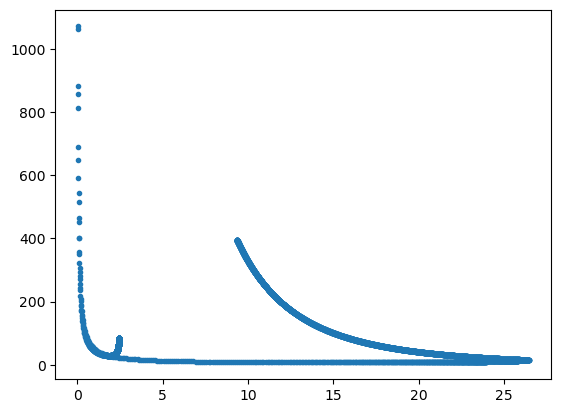

In [52]:
plot_cooling(emissions)

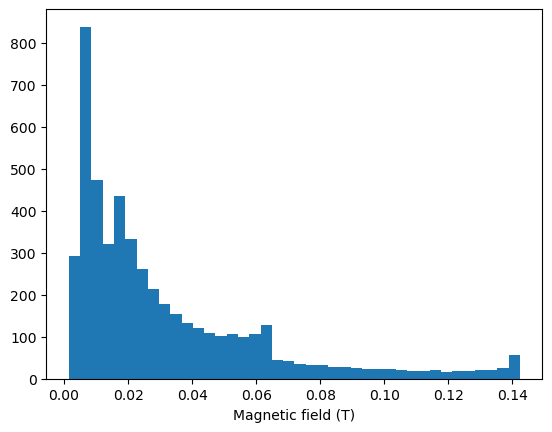

In [53]:
hist_b_field(emissions)

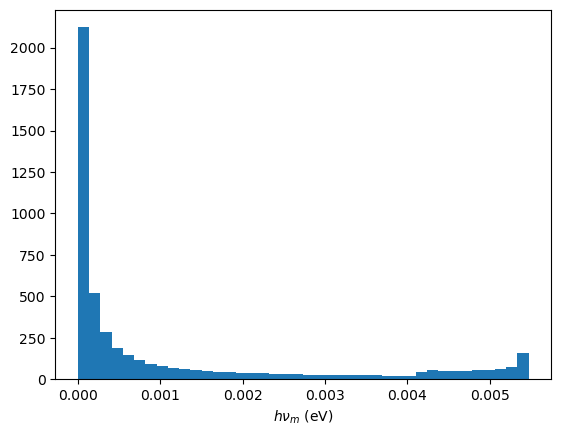

In [54]:
hist_nu_m(emissions)

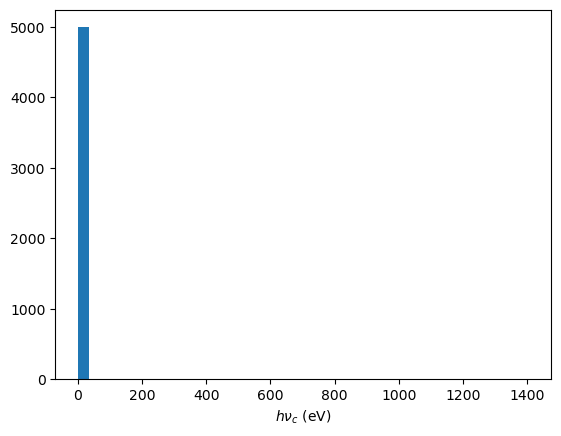

In [55]:
hist_nu_c(emissions)

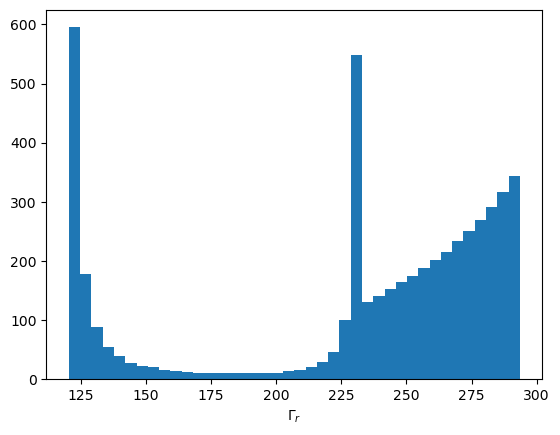

In [56]:
hist_gamma_r(emissions)

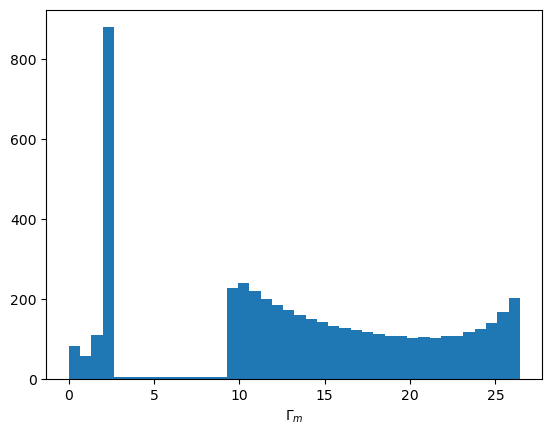

In [57]:
hist_gamma_m(emissions)

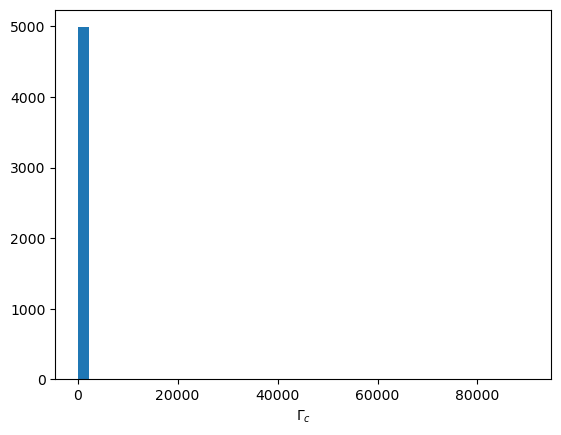

In [58]:
hist_gamma_c(emissions)

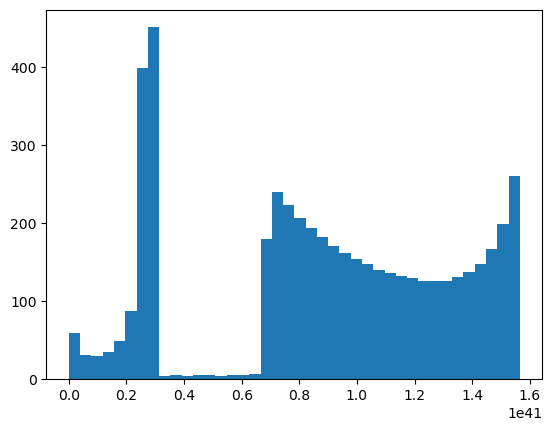

In [59]:
hist_energy(emissions)

In [65]:
simus = [Simulation(gamma_profile=gamma_profile_atan, energy_rate=1e41),
         Simulation(gamma_profile=gamma_profile_atan, energy_rate=1e42),
         Simulation(gamma_profile=gamma_profile_atan, energy_rate=1e43),
         Simulation(gamma_profile=gamma_profile_atan, energy_rate=1e44),
         Simulation(gamma_profile=gamma_profile_atan, energy_rate=1e45),
         Simulation(gamma_profile=gamma_profile_atan, energy_rate=1e46),
         Simulation(gamma_profile=gamma_profile_atan, energy_rate=1e47),
         Simulation(gamma_profile=gamma_profile_step, energy_rate=1e41),
         Simulation(gamma_profile=gamma_profile_step, energy_rate=1e42),
         Simulation(gamma_profile=gamma_profile_step, energy_rate=1e43),
         Simulation(gamma_profile=gamma_profile_step, energy_rate=1e44),
         Simulation(gamma_profile=gamma_profile_step, energy_rate=1e45),
         Simulation(gamma_profile=gamma_profile_step, energy_rate=1e46),
         Simulation(gamma_profile=gamma_profile_step, energy_rate=1e47),     
        ]

emissions = []
for n, simu in enumerate(simus):
    simu.run()
    emissions.append(emission_list_from_simulation(simu))
    print(f"Completed simulation {n+1}/{len(simus)}")


Completed simulation 1/14
Completed simulation 2/14
Completed simulation 3/14
Completed simulation 4/14
Completed simulation 5/14
Completed simulation 6/14
Completed simulation 7/14
Completed simulation 8/14
Completed simulation 9/14
Completed simulation 10/14
Completed simulation 11/14
Completed simulation 12/14
Completed simulation 13/14
Completed simulation 14/14


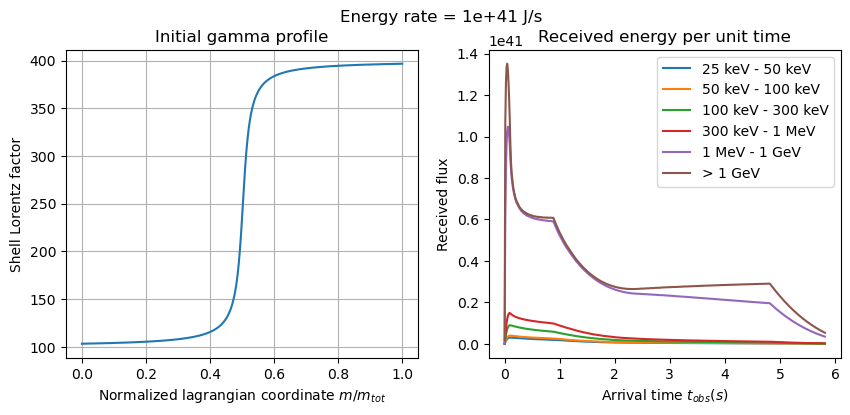

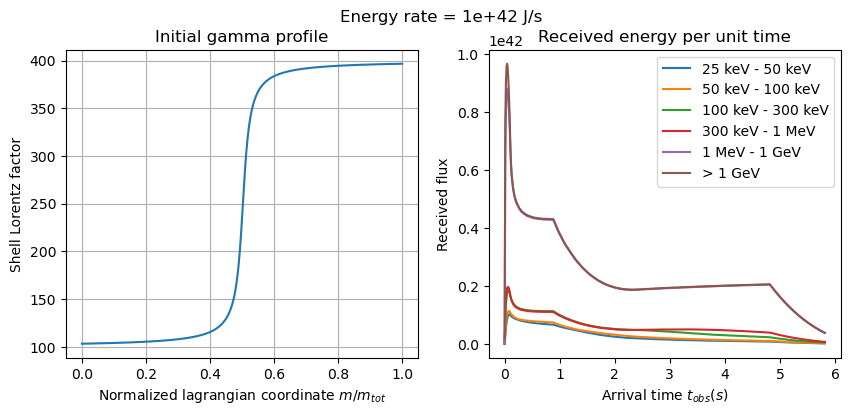

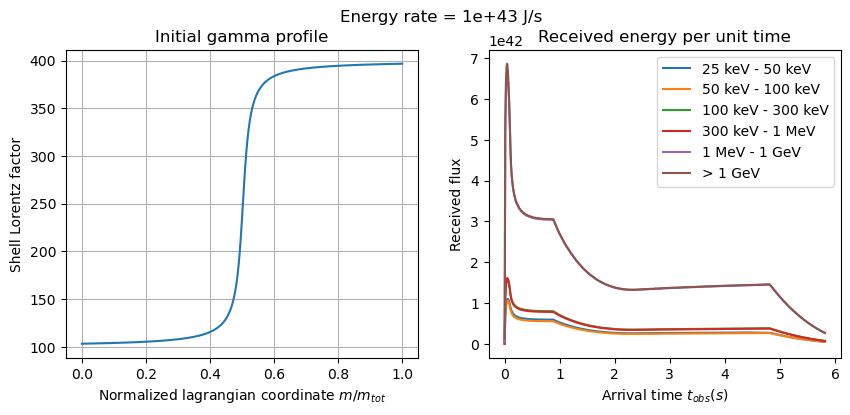

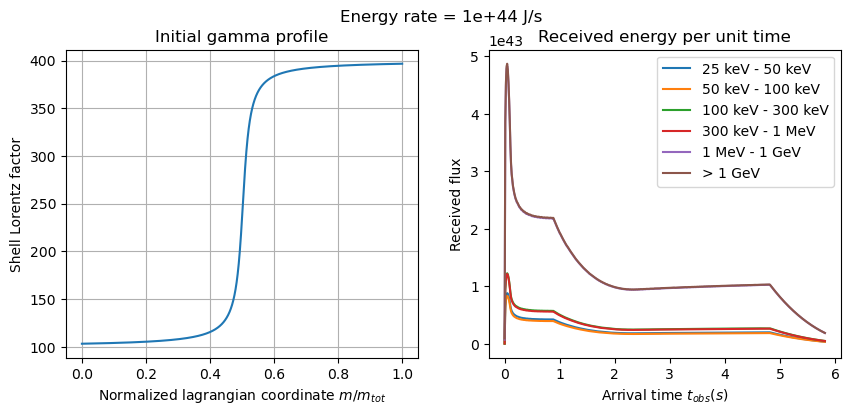

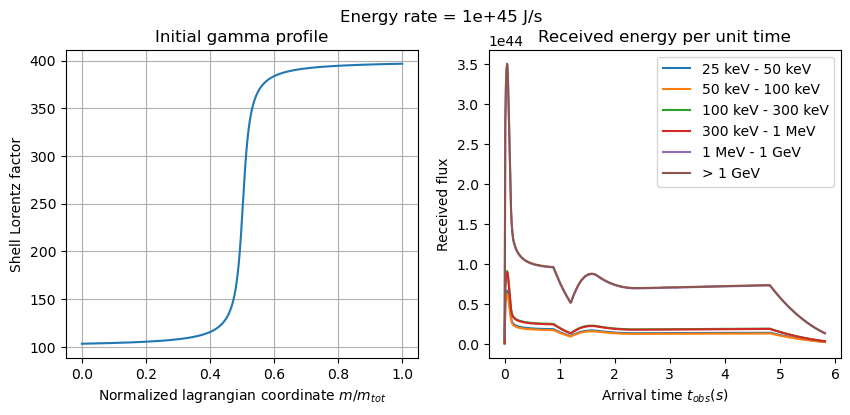

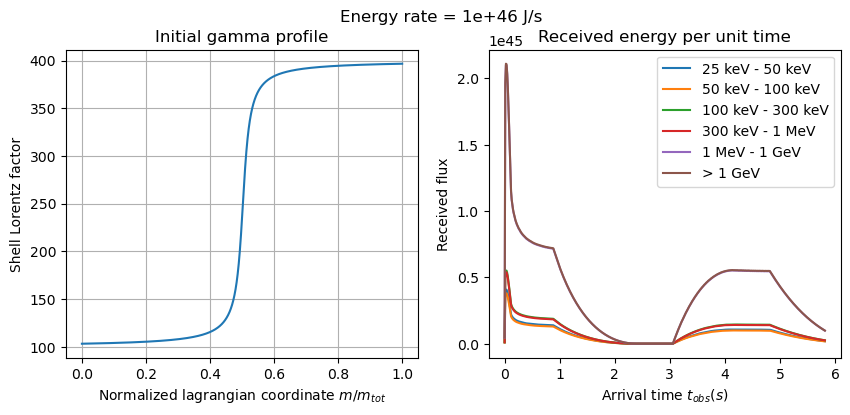

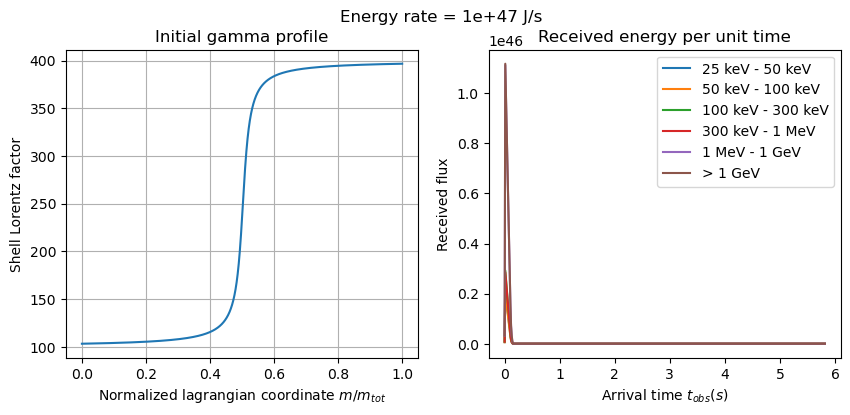

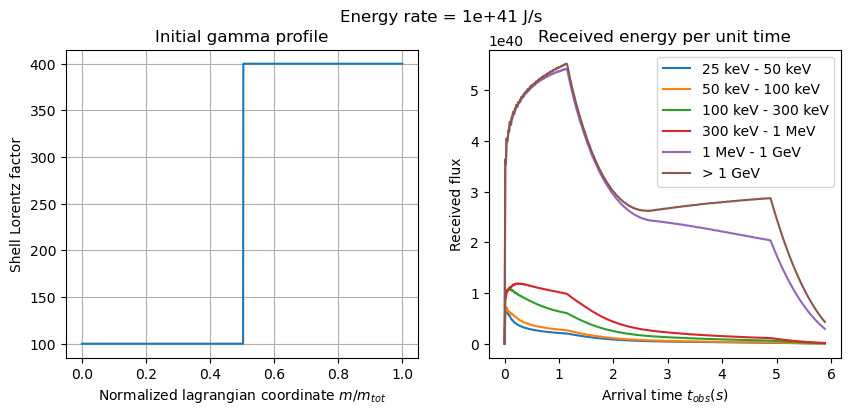

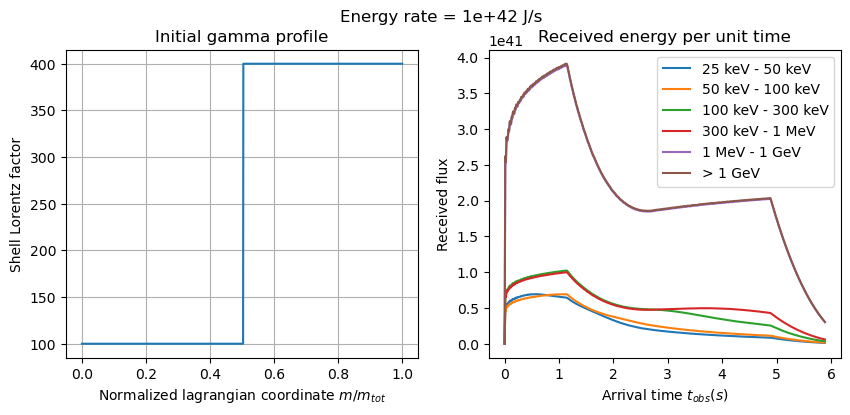

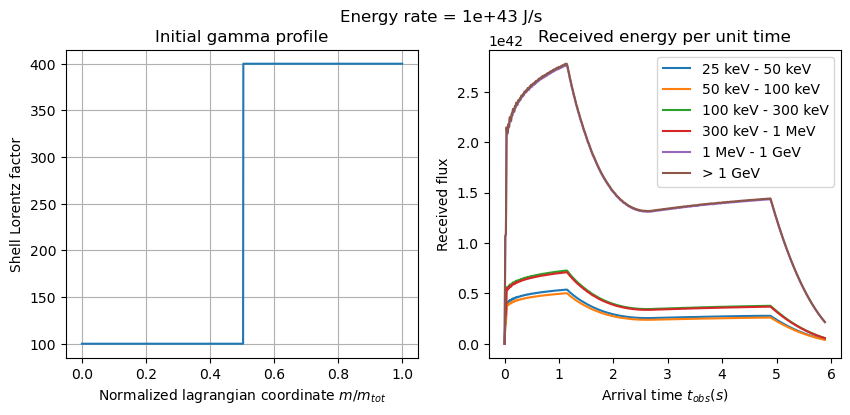

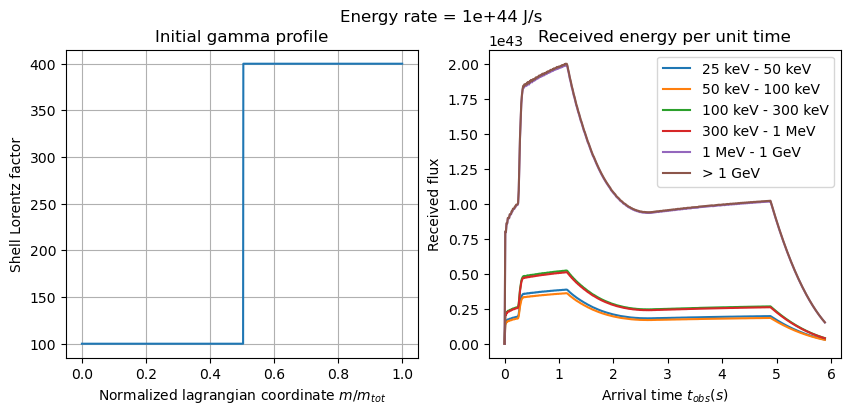

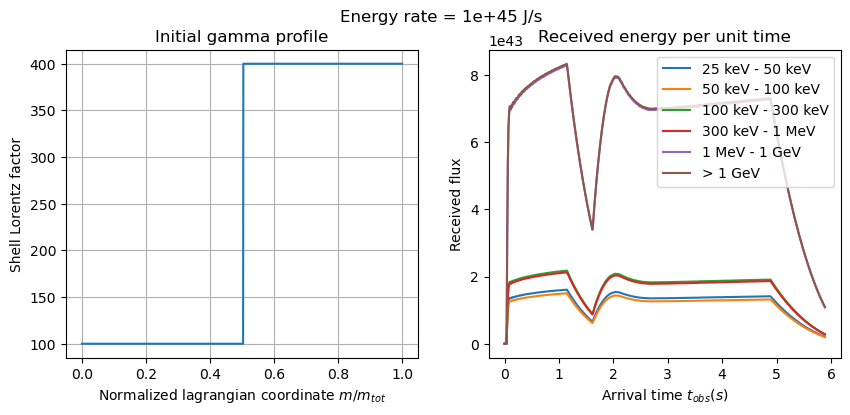

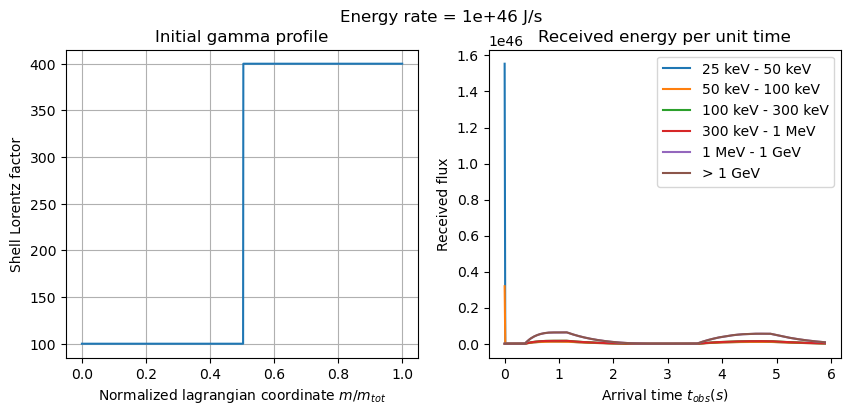

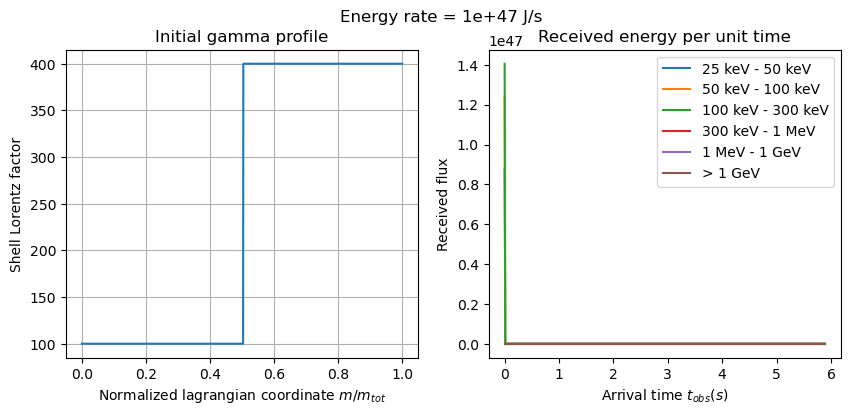

In [66]:


for simu, emiss in zip(simus, emissions):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

    plot_initial_gamma(simu, ax1)
    standard_bolometric_plot(emiss, maxtime=None, ax=ax2)
    plt.suptitle(f"Energy rate = {simu.energy_rate} J/s")

    plt.show()